# DBSCAN and HDBSCAN

The "Density-Based Spatial Clustering of Applications with Noise" (DBSCAN) algorithm defines clusters as continuous regions of high density. Thus, it can identify complex shaped clusters. Furthermore, one must not provide a guess for the number of clusters. Noisy data is identified as outliers. However, the algorithm fails for overlapping clusters where Gaussian mixtures provide a solution. The DBSCAN algorithm work as follow:
1. It counts how many instances are located within a small distance $\epsilon$ of a single instance.
2. If an instance has at least $k$ instances in its neighborhood, this instance is considered as core instance.
3. All instances close to a core instance belong to the same cluster. Multiple core instances can be linked to each other forming a large cluster.
4. All instances which are neither a core instance or sufficient close to a core instance are count as anomaly.

You can use DBSCAN with scikit-learn by:

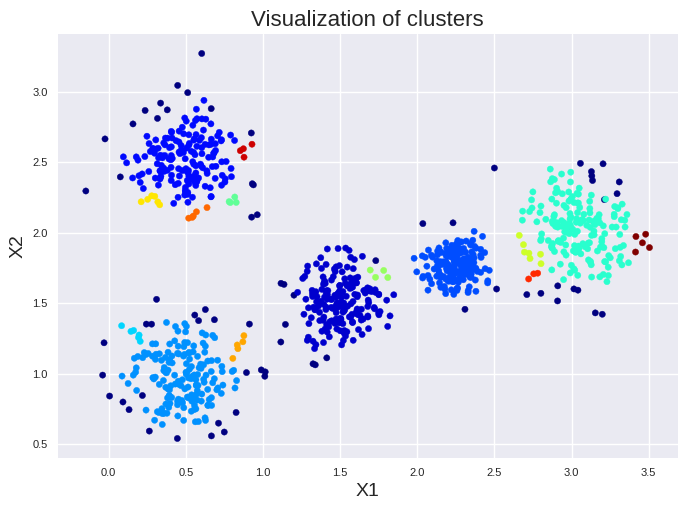

In [29]:
from sklearn.cluster import DBSCAN
import pandas as pd

X = pd.read_csv('cluster1_data.csv')

# Please note, min_samples includes the core instance itself. 
dbscan = DBSCAN(eps=0.08, min_samples=4)
dbscan.fit(X)

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

plt.scatter(X["X1"], X["X2"], c=dbscan.labels_, cmap=plt.cm.jet, s=20)
plt.title("Visualization of clusters", fontsize=16)
plt.xlabel("X1", fontsize=14)
plt.ylabel("X2", fontsize=14)
plt.tick_params(labelsize=8)

plt.show()

We set min_samples to 4 since twice the number of input features $n$ is a good start for this approach. Please note, min_samples is $k+1$ since min_samples includes the core instance. We found five large clusters and several small one. The dark blue dots highlight the anomalies. We can get on overview of the number of instances in each cluster by:  

In [2]:
print(pd.DataFrame(dbscan.labels_).value_counts())

0  
 2     196
 0     188
 5     168
 1     164
 3     164
-1      71
 8       7
 4       6
 9       6
 14      5
 10      5
 11      5
 6       4
 7       4
 13      4
 12      3
Name: count, dtype: int64


Please note, anomalies are always listed as -1. The small clusters have less then 10 instances. Thus, they should be removed if we increase min_samples slightly.

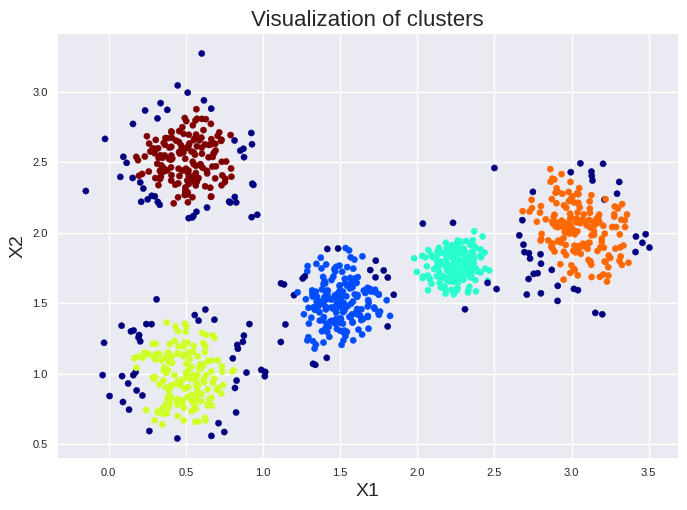

In [30]:
dbscan = DBSCAN(eps=0.08, min_samples=6)
dbscan.fit(X)

plt.style.use('seaborn-v0_8')

plt.scatter(X["X1"], X["X2"], c=dbscan.labels_, cmap=plt.cm.jet, s=20)
plt.title("Visualization of clusters", fontsize=16)
plt.xlabel("X1", fontsize=14)
plt.ylabel("X2", fontsize=14)
plt.tick_params(labelsize=8)

plt.show()

In [4]:
print(pd.DataFrame(dbscan.labels_).value_counts())

0 
 1    195
 0    182
 3    164
 2    157
 4    157
-1    145
Name: count, dtype: int64


However, the question arises: How do we choose a good guess for $\epsilon$? If you have $n$ input features, calculate the distance of each instance to the closest $2n-1$ neighbors. Sort the calculated distances and plot them to find the elbow separating noisy points with large nearest neighbor distance from points with relatively low neighbor distance. The distance at which this "elbow" occurs is the optimal $\epsilon$.

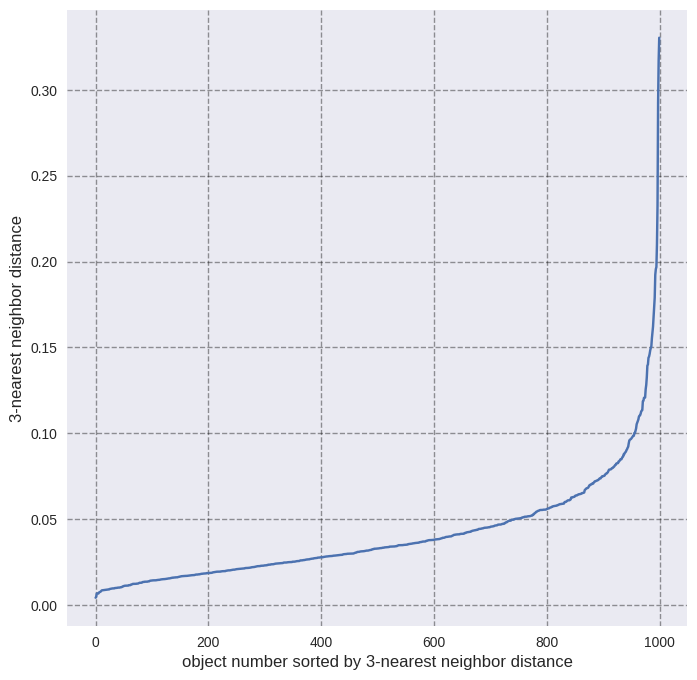

In [5]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def get_dist_plot(X=None, nn=None, radius_nnbrs=1.0):

    # Do an unsupervised neighbor search
    nnbrs = NearestNeighbors(n_neighbors=nn, radius=radius_nnbrs).fit(X)

    # Get the distances of the nearest neighbors
    distances, indices = nnbrs.kneighbors(X) 

    # Sort them according to their value
    distances = np.sort(distances, axis=0)

    # Take the distance to the neighbor which is in the last column 
    # This is the largest distance of the nearest neighbors.
    distances = distances[:, nn-1]

    # Plot the sorted distances for each point in the data set
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('object number sorted by {}-nearest neighbor distance'.format(nn), fontsize=12)
    plt.ylabel('{}-nearest neighbor distance'.format(nn), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()

get_dist_plot(X=X, nn=3)

We see the elbow at 0.08 which we have used as $\epsilon$ in the DBSCAN clustering. 

We can also get a list of our core instances with the respective coordinates: 

In [9]:
print("These are the indices of the first five core instances:")
print(dbscan.core_sample_indices_[:5])

print("\n These are the coordinates of the first five core instances:")
print(dbscan.components_[:5])

These are the indices of the first five core instances:
[0 1 3 4 6]

 These are the coordinates of the first five core instances:
[[1.65360938 1.58887904]
 [1.74918888 1.43143556]
 [2.35760071 1.75213116]
 [0.34872985 0.71554926]
 [2.14934574 1.86398786]]


DBSCAN has no possibility to predict to which cluster a new data point might belong. However, we can easily train a nearest neighbor classifier based on our labeled data and use it subsequently to predict the class of a new data point:

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

knn.predict([[0.5, 1.5]])

array([2])

A better choice then DBSCAN is in most cases Hierarchical DBSCAN (HDBSCAN) which automatically explores varying density scales. HDBSCAN needs mainly the minimum cluster size as hyperparameter, making it more robust, less sensitive to noise, and better suited for data with mixed cluster densities. The minimum cluster size is just set to the smallest cluster size you like to have. Information on the choice of other hyperparameters can be found here: <a href="https://hdbscan.readthedocs.io/en/latest/parameter_selection.html">Link to HBDSCAN documentation</a>. Information on the math behind the HDBSCAN approach can be found here: <a href="https://arxiv.org/abs/1705.07321">Link to publication</a>

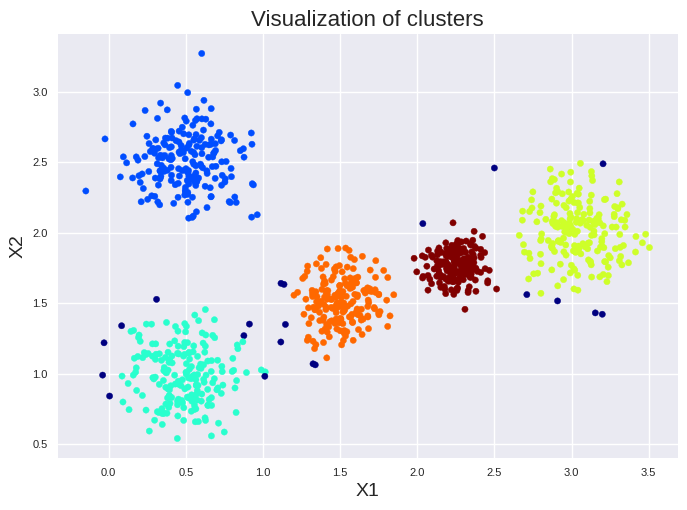

In [38]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=10)
hdbscan.fit(X)

plt.style.use('seaborn-v0_8')

plt.scatter(X["X1"], X["X2"], c=hdbscan.labels_, cmap=plt.cm.jet, s=20)
plt.title("Visualization of clusters", fontsize=16)
plt.xlabel("X1", fontsize=14)
plt.ylabel("X2", fontsize=14)
plt.tick_params(labelsize=8)

plt.show()